In [1]:
from scipy import sparse
import numpy as np
import itertools
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from scipy.stats import gaussian_kde
from tqdm import tqdm_notebook
from seaborn import kdeplot

import sys
sys.path.append("..")
import utils

from statsmodels.distributions import ECDF

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [89]:
fps = sparse.load_npz('../time_split/morgan.npz')
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
assays_long = pd.read_csv('assays_long.csv')
smiles = pd.read_csv('../data/pchembl_chemicals.csv')
                     

In [7]:
def fast_dice(X, Y=None):
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X).astype(bool).astype(int)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y).astype(bool).astype(int)

    intersect = X.dot(Y.T)
    #cardinality = X.sum(1).A
    cardinality_X = X.getnnz(1)[:,None] #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    cardinality_Y = Y.getnnz(1) #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    return (1-(2*intersect) / (cardinality_X+cardinality_Y.T)).A


##The following is to calculate AVE bias:
def fast_jaccard(X, Y=None):
    """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y)
    assert X.shape[1] == Y.shape[1]

    X = X.astype(bool).astype(int)
    Y = Y.astype(bool).astype(int)
    intersect = X.dot(Y.T)
    x_sum = X.sum(axis=1).A1
    y_sum = Y.sum(axis=1).A1
    xx, yy = np.meshgrid(x_sum, y_sum)
    union = ((xx + yy).T - intersect)
    return (1 - intersect / union).A

In [53]:
assays_long.head()

,Unnamed: 0,ligandIdx,targetIdx,instance_id,pref_name,outcome,assayname
0,0,236194,84,CHEMBL3908870,Serotonin 2a (5-HT2a) receptor,Unspecified,Displacement of [3H]-ketanserin from human 5-H...
1,1,153449,194,CHEMBL3401988,PI3-kinase p110-alpha subunit,Unspecified,Inhibition of PI3Kalpha (unknown origin)
2,2,16124,194,CHEMBL1242661,PI3-kinase p110-alpha subunit,Unspecified,Inhibition of recombinant PI3Kalpha by radioac...
3,3,57881,164,CHEMBL1908395,Rho-associated protein kinase 1,Unspecified,Binding constant for ROCK1 kinase domain
4,4,311049,138,CHEMBL50894,Vascular endothelial growth factor receptor 2,Unspecified,Millipore: Percentage of residual kinase activ...


In [54]:
actives_df = pd.DataFrame(assays_long.groupby(['ligandIdx', 'targetIdx']).apply( 
    lambda grouped_df: (grouped_df['outcome'].str.contains('Active').any())))

actives_df=actives_df[actives_df[0]==True].reset_index()
actives_df.head()

,ligandIdx,targetIdx,0
0,917,199,True
1,974,82,True
2,993,162,True
3,3267,36,True
4,3325,149,True


In [73]:
similarities = list()
for count, ligId, targId in zip(range(len(actives_df)), actives_df['ligandIdx'], actives_df['targetIdx']):
    print(count, end = '\r')
    allSimilarities = fast_dice(fps[ligId], fps[(interaction_matrix[:,targId]==1).toarray().flatten()])
    similarities.append(allSimilarities.min())
    
similarities = np.array(similarities)

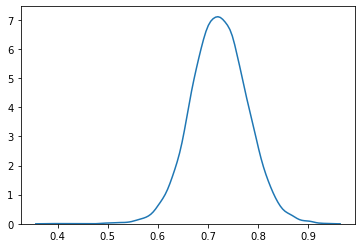

In [81]:
numrandom = 100
kdeplot(fast_dice(fps[np.random.choice(range(fps.shape[0]), numrandom)],
          fps[np.random.choice(range(fps.shape[0]), numrandom)]).flatten())

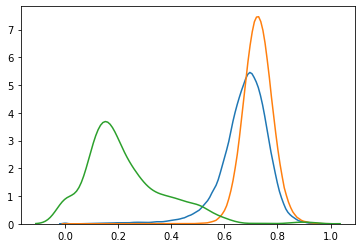

In [120]:
targetidx = np.random.choice(interaction_matrix.shape[1])
ligands = fps[(interaction_matrix[:,targId]==1).toarray().flatten()]


kdeplot(fast_dice(ligands[np.random.choice(range(ligands.shape[0]), numrandom)],
          ligands[np.random.choice(range(ligands.shape[0]), numrandom)]).flatten())

numrandom = 1000
kdeplot(fast_dice(fps[np.random.choice(range(fps.shape[0]), numrandom)],
          fps[np.random.choice(range(fps.shape[0]), numrandom)]).flatten())

kdeplot(similarities)

In [74]:
similarities[np.argsort(-similarities)[:10]]

array([0.92592593, 0.92      , 0.89473684, 0.88235294, 0.85714286,
       0.73913043, 0.63636364, 0.61006289, 0.60509554, 0.6039604 ])

In [101]:
np.argsort(-similarities)[:10]

array([192,  29,  93, 209,  74,  73,  26, 339, 340, 648])

In [114]:
actives_df.iloc[73]

ligandIdx    37957
targetIdx       52
0             True
Name: 73, dtype: object

In [115]:
fast_dice(fps[54432], fps[(interaction_matrix[:,52]==1).toarray().flatten()]).min()
#similarities.append(allSimilarities.min())

0.8947368421052632

In [117]:
smiles.iloc[37957]

instance_id         CHEMBL1644696
canonical_smiles    [Na+].[O-]C#N
Name: 37957, dtype: object

In [93]:
np.argsort(-similarities)[:10]

array([192,  29,  93, 209,  74,  73,  26, 339, 340, 648])

In [91]:
interaction_matrix

<337951x243 sparse matrix of type '<class 'numpy.float64'>'
	with 483643 stored elements in Compressed Sparse Row format>

In [92]:
len(smiles)

337951

(array([50.,  0., 10.,  5., 19., 27., 50., 49., 55., 42., 60., 34., 33.,
        27., 26., 26., 25., 11., 17., 16., 13., 13., 11., 12., 10., 13.,
        10.,  9.,  7.,  8., 16.,  5.,  2.,  6.,  2.,  5.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  1.,  2.]),
 array([0.        , 0.01683502, 0.03367003, 0.05050505, 0.06734007,
        0.08417508, 0.1010101 , 0.11784512, 0.13468013, 0.15151515,
        0.16835017, 0.18518519, 0.2020202 , 0.21885522, 0.23569024,
        0.25252525, 0.26936027, 0.28619529, 0.3030303 , 0.31986532,
        0.33670034, 0.35353535, 0.37037037, 0.38720539, 0.4040404 ,
        0.42087542, 0.43771044, 0.45454545, 0.47138047, 0.48821549,
        0.50505051, 0.52188552, 0.53872054, 0.55555556, 0.57239057,
        0.58922559, 0.60606061, 0.62289562, 0.63973064, 0.65656566,
        0.67340067, 0.69023569, 0.70707071, 0.72390572, 0.74074074,
        0.75757576, 0.77441077, 0.79124579, 0.80808081, 0.82491582,
   

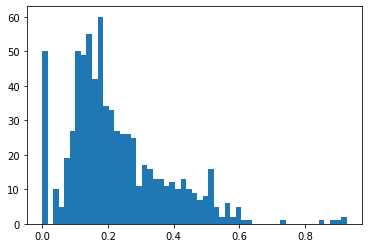

In [65]:
from seaborn import kdeplot
plt.hist(similarities, bins=55)